In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import astropy.units as u
from astropy.io import fits
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
from importlib import reload

import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import scoobpsf
from scoobpsf.math_module import xp, _scipy
from scoobpsf.imshows import *
from scoobpsf import scoob

import lina

pupil_diam = 6.75*u.mm 
lyot_diam = 3.6*u.mm
det_rotation = -7.5 #  degrees of rotation of the detector relative to the optical axis

# The flattest wavefront obtained for the system in the lab by
# performing phase diversity
dm_flat = fits.getdata(scoob.module_path/'scoob_dm_flat.fits')

wavelength_c = 632.8e-9*u.m # central wavelength
npix = 512
oversample = 8

vortex = scoobpsf.agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6, singularity=20*u.um)
lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=lyot_diam/2.0)

Model using synthetic OPD data


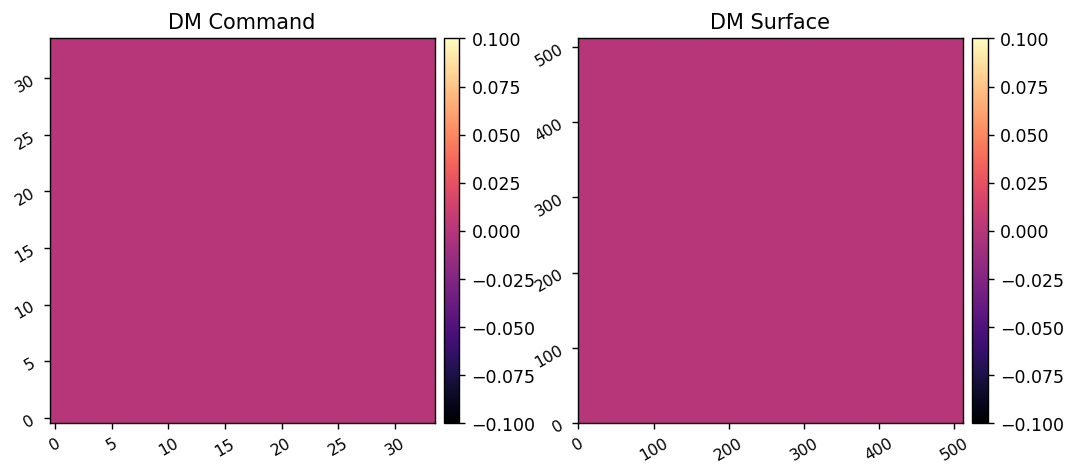

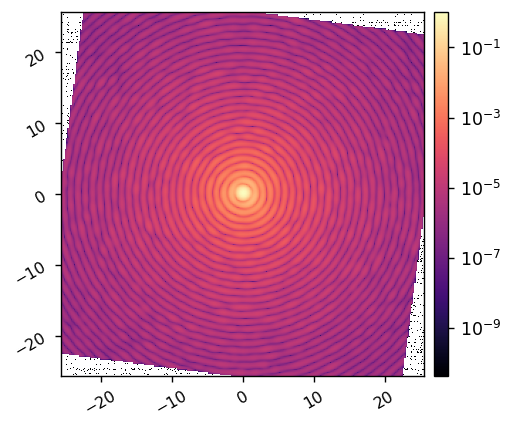

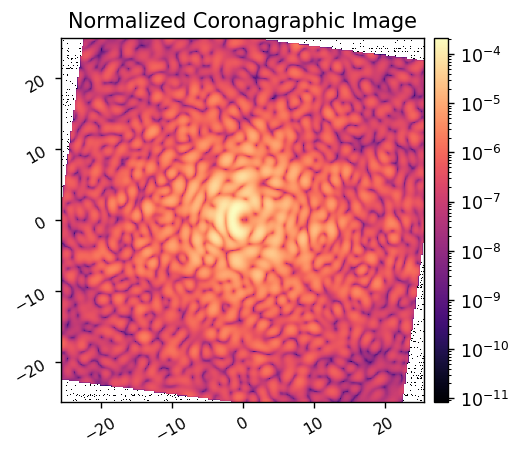

In [6]:
reload(scoob)
model = scoob.SCOOBM(npix=npix, 
                      oversample=oversample, 
                     npsf=256,
                      wavelength=wavelength_c, 
                      pupil_diam=pupil_diam,
                      det_rotation=det_rotation, 
                      use_synthetic_opds=True,
#                       dm_ref=dm_flat,
                     )

model.show_dm()

im0 = model.snap()
model.Imax_ref = im0.max()

ref_unocc_im = model.snap(plot=True)

model.FPM = vortex
model.LYOT = lyot_stop

ref_im = model.snap()
imshow1(ref_im, 'Normalized Coronagraphic Image', 
        lognorm=True, 
        pxscl=model.psf_pixelscale_lamD)

In [12]:
%%timeit
ref_im = model.snap()


604 ms ± 285 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


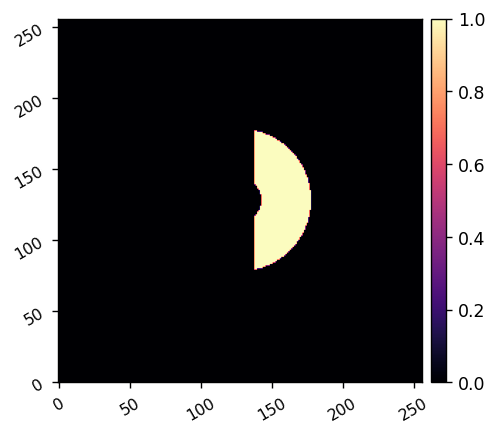

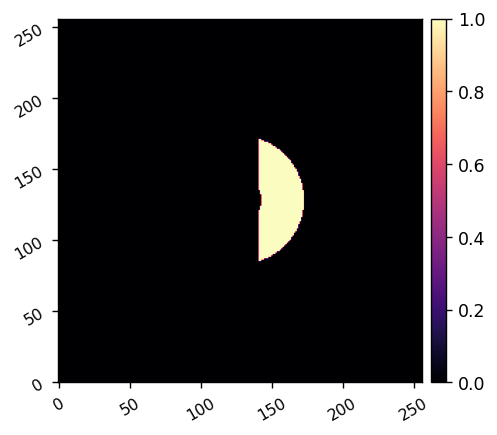

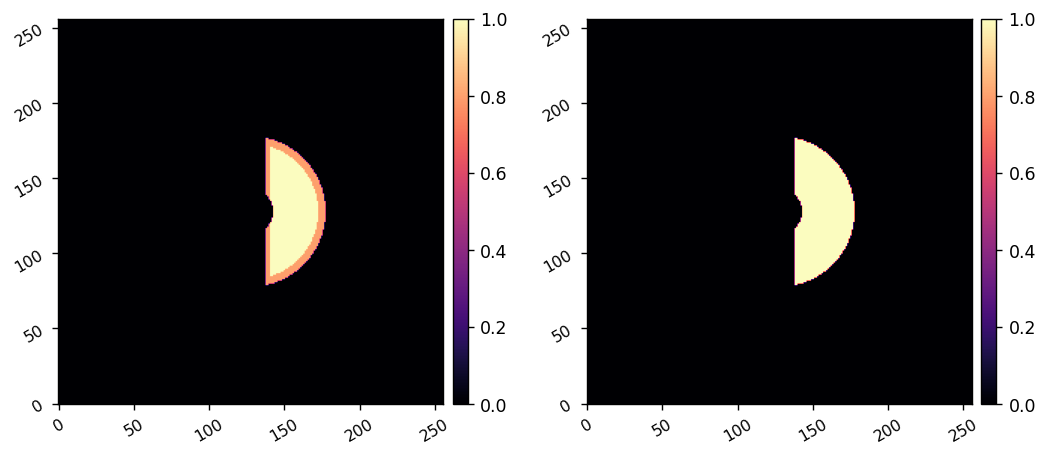

In [7]:
reload(lina.utils)
iwa = 3
owa = 10
edge = 2
roi1 = lina.utils.create_annular_focal_plane_mask(model, iwa, owa, edge=edge, shift=(0,0), rotation=0, plot=True)
roi2 = lina.utils.create_annular_focal_plane_mask(model, iwa, 9, edge=2.5, shift=(0,0), rotation=0, plot=True)

weight_map = 0.8*(roi1 * ~roi2) + roi2
control_mask = weight_map>0
imshow2(weight_map, control_mask)

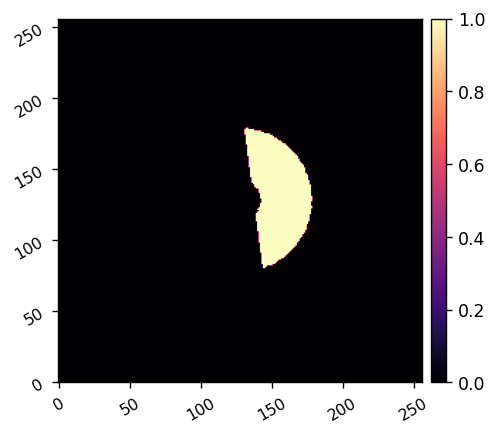

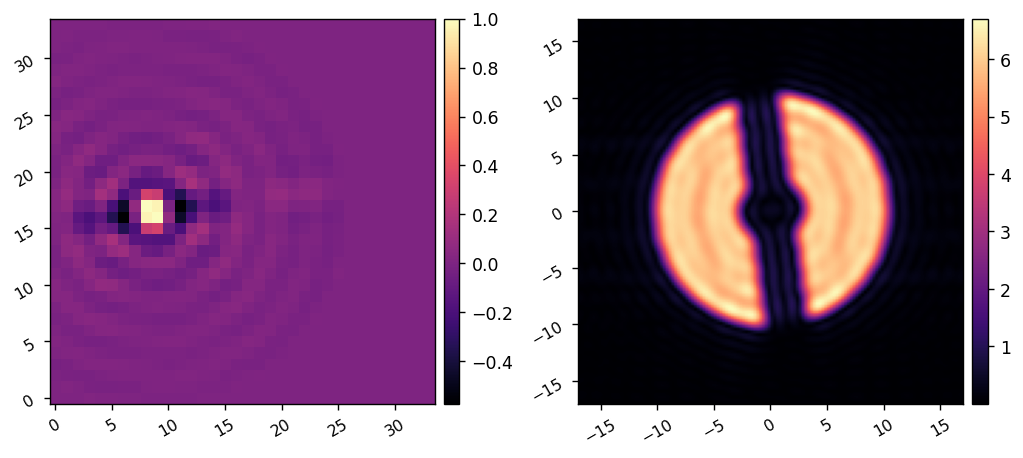

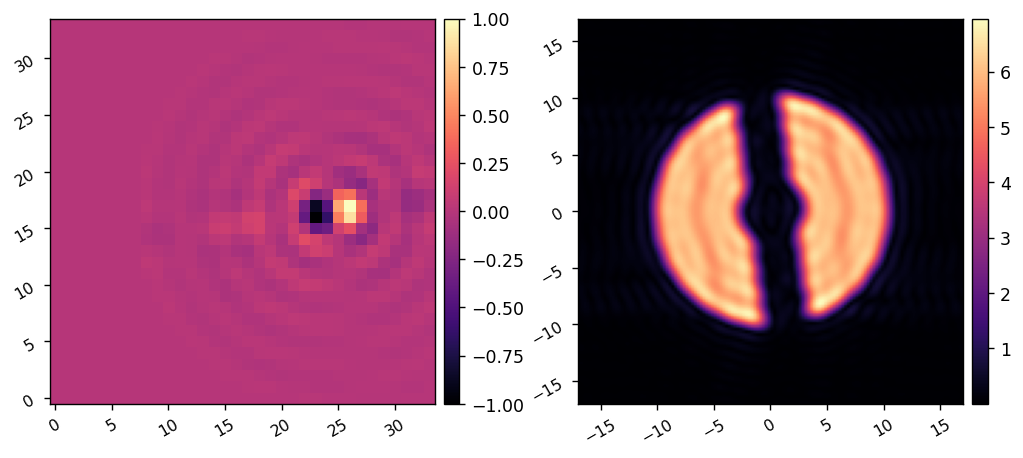

In [8]:
control_mask_for_probes = _scipy.ndimage.rotate(control_mask, model.det_rotation, reshape=False, order=1)
imshow1(control_mask_for_probes)

reload(lina.utils)
probe_amp = 2e-8

probe_modes = lina.utils.create_fourier_probes(model, control_mask_for_probes, fourier_sampling=0.2, shift=[(-8,0), (8,0)], nprobes=2, 
                                               plot=True, calc_responses=True)

228

114

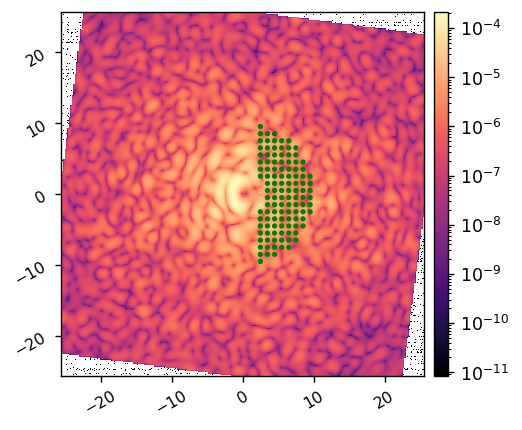

In [11]:
reload(lina.utils)

calib_amp = 5e-9
calib_modes, fs = lina.utils.create_fourier_modes(model, control_mask, fourier_sampling=1, return_fs=True) 
nmodes = calib_modes.shape[0]
nf = nmodes//2
display(nmodes, nf)

patches = []
for f in fs:
    center = (f[0], f[1])
    radius = 0.25
    patches.append(Circle(center, radius, fill=True, color='g'))
    
imshow1(ref_im, lognorm=True, pxscl=model.psf_pixelscale_lamD, patches=patches)

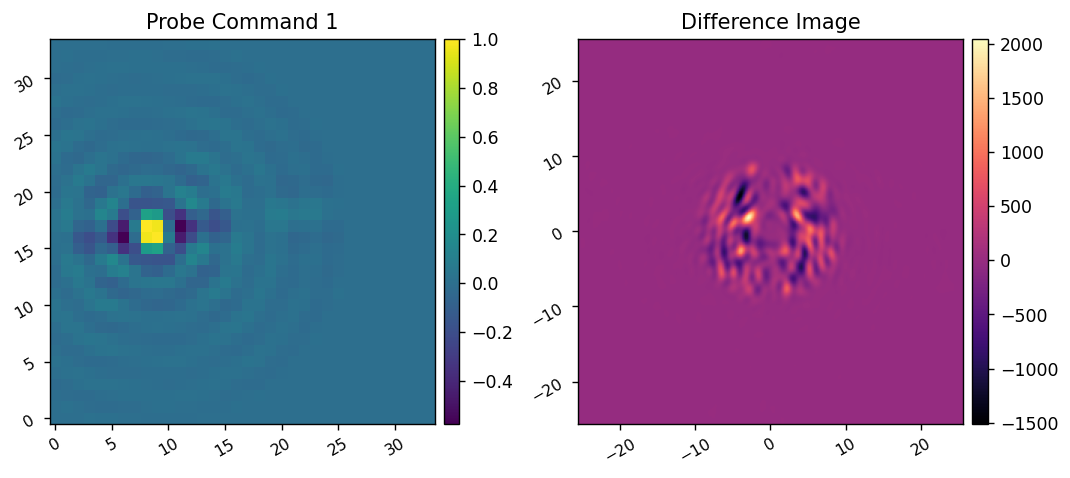

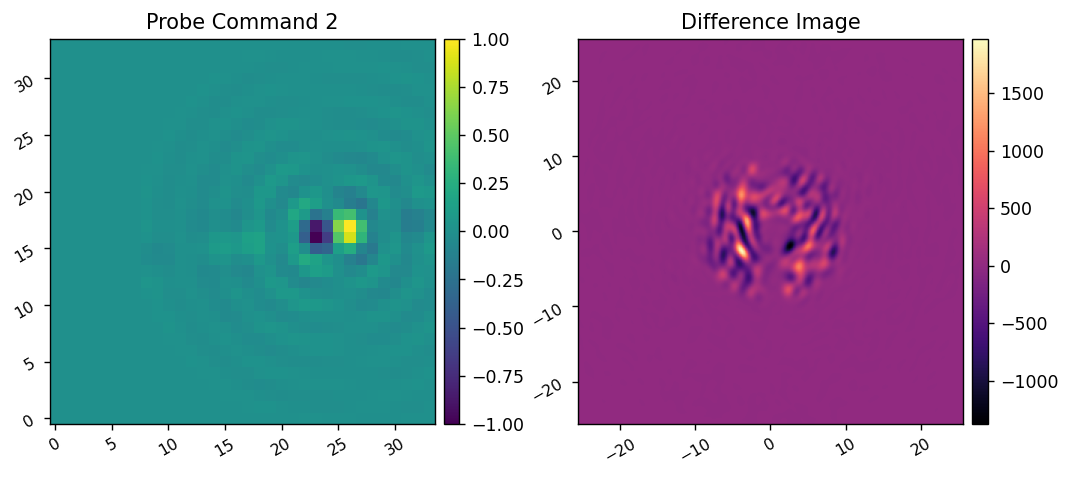

In [10]:
reload(lina.iefc)
model.reset_dm()
differential_images = lina.iefc.take_measurement(model, probe_modes, probe_amp, plot=True)
# ims = differential_images.reshape(probe_modes.shape[0], model.npsf, model.npsf)
# imshow3(ims[0], ims[1], ims[2], wspace=0.35)


In [12]:
reload(lina.iefc)
model.reset_dm()
response_matrix, response_cube = lina.iefc.calibrate(model, control_mask, probe_amp, probe_modes, calib_amp, calib_modes, return_all=True)

Calibrating iEFC...
	Calibrated mode 228 / 228 in 1108.31s
Calibration complete.


In [14]:
response_matrix.shape, response_cube.shape

((5712, 228), (228, 2, 65536))

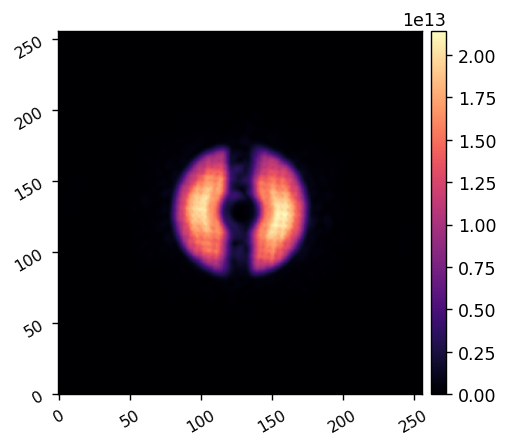

In [13]:
response_sum = xp.sum(abs(response_cube), axis=(0,1))
imshow1(response_sum.reshape(model.npsf,model.npsf))

In [33]:
probe_modes.shape

(3, 34, 34)

In [39]:
response_matrix.shape

(5712, 228)

(5712, 5712) (5712, 228)
Running iEFC...
	Closed-loop iteration 1 / 5
(5712,)
(228, 5712)
	Mean NI of this iteration: 1.700e-06


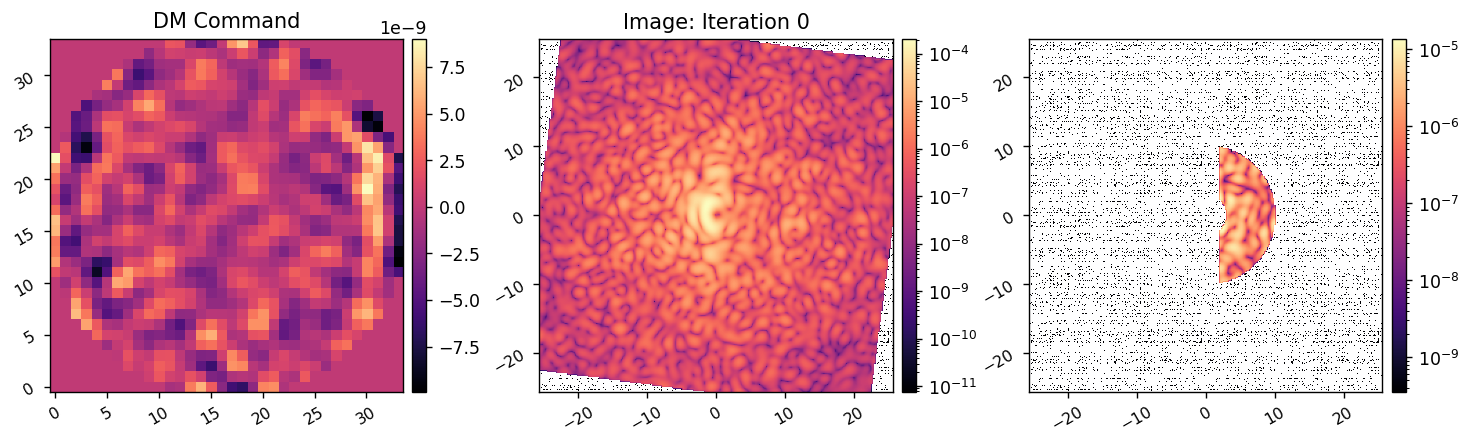

/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


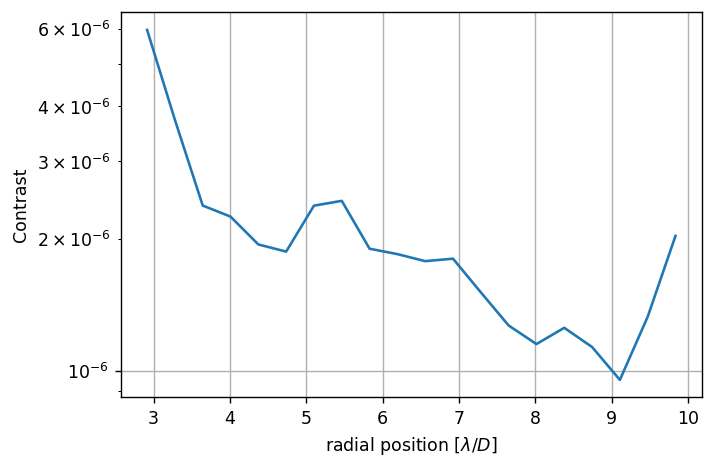

	Closed-loop iteration 2 / 5
(5712,)
(228, 5712)
	Mean NI of this iteration: 5.803e-07


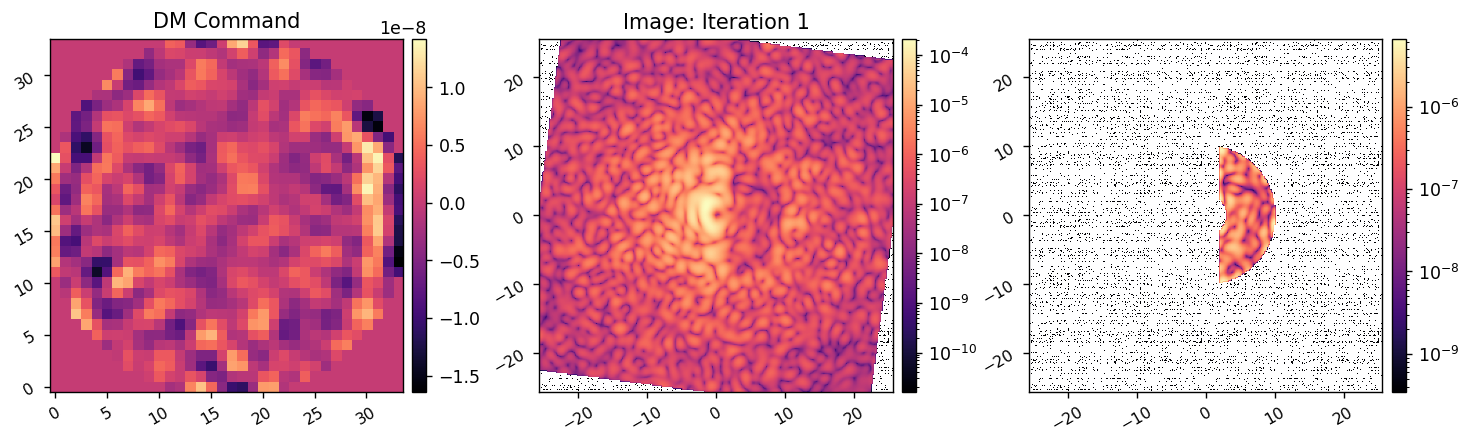

/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


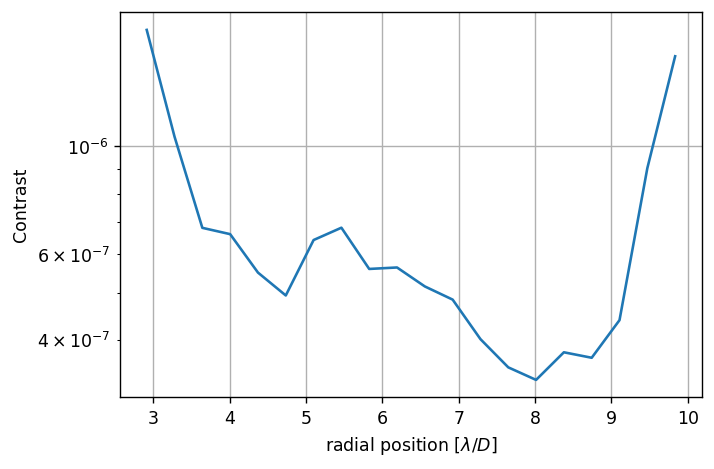

	Closed-loop iteration 3 / 5
(5712,)
(228, 5712)
	Mean NI of this iteration: 2.846e-07


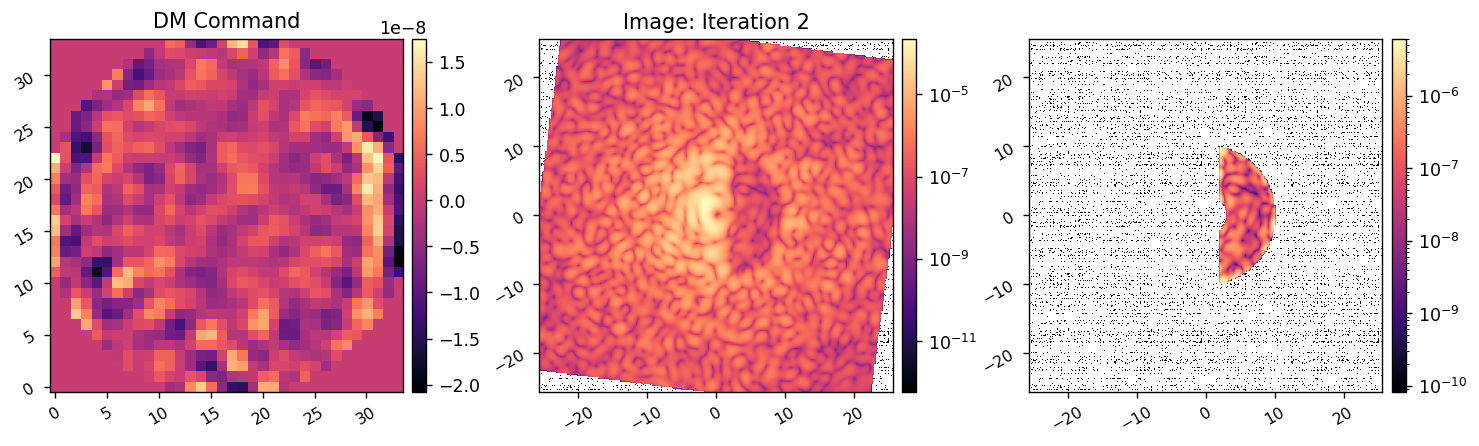

/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


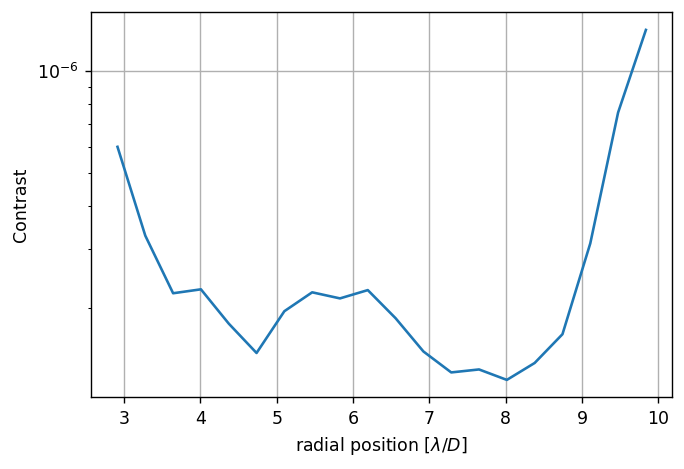

	Closed-loop iteration 4 / 5
(5712,)
(228, 5712)
	Mean NI of this iteration: 2.018e-07


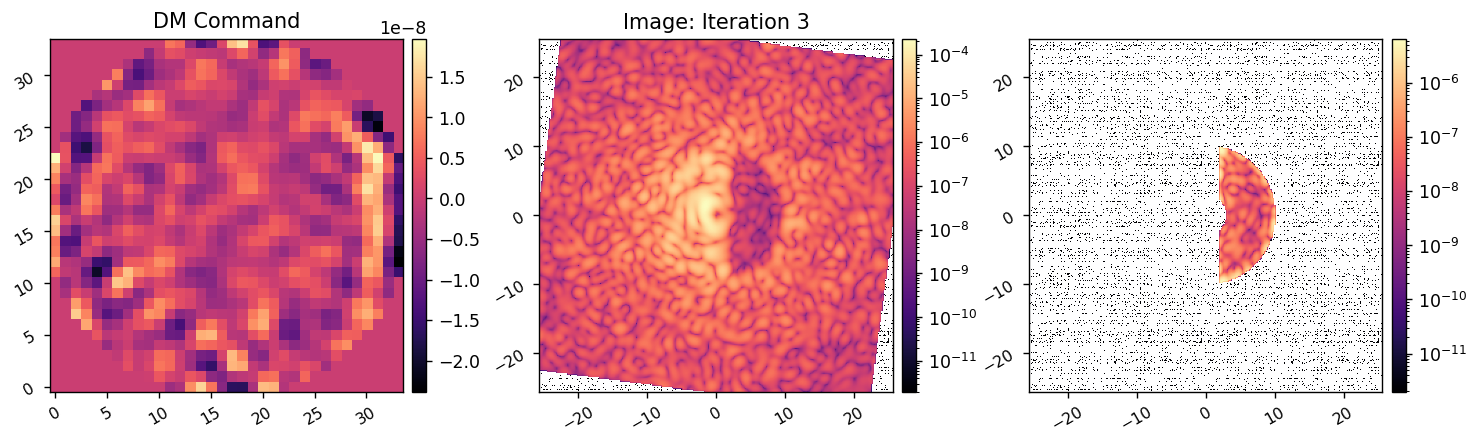

/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


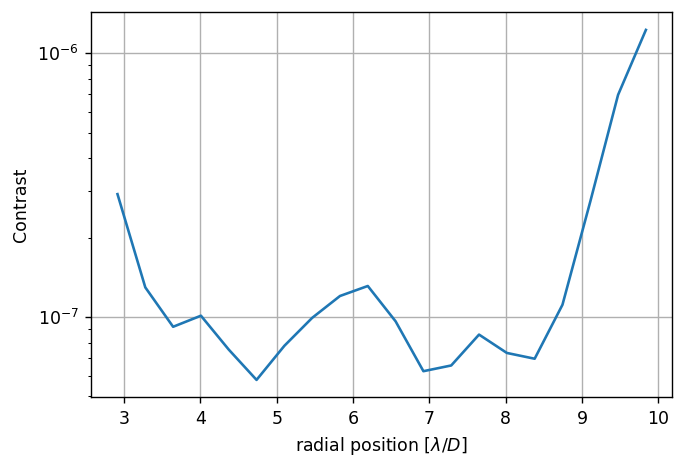

	Closed-loop iteration 5 / 5
(5712,)
(228, 5712)
	Mean NI of this iteration: 1.756e-07


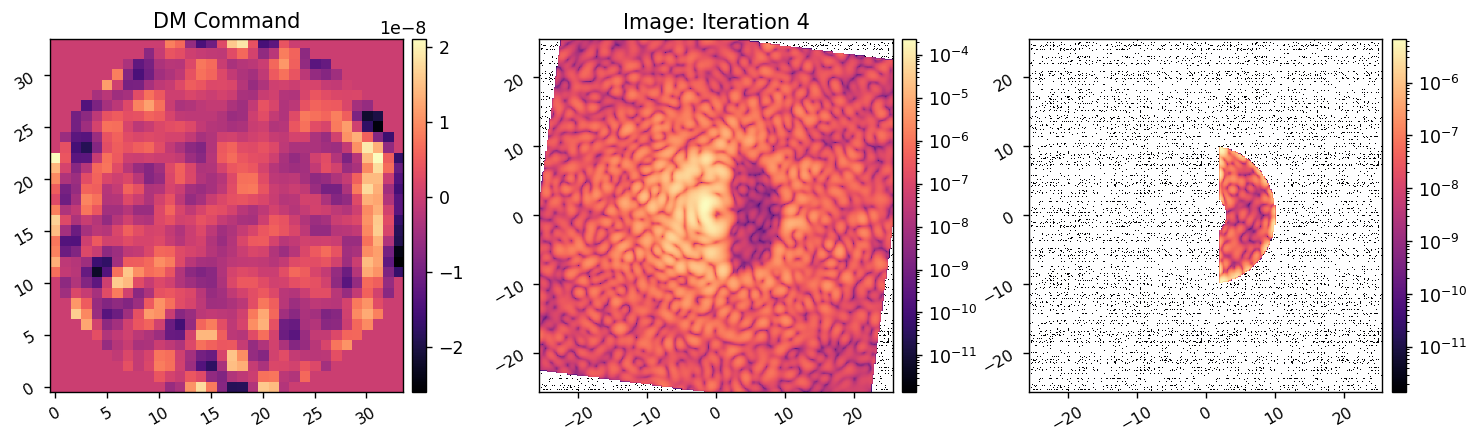

/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


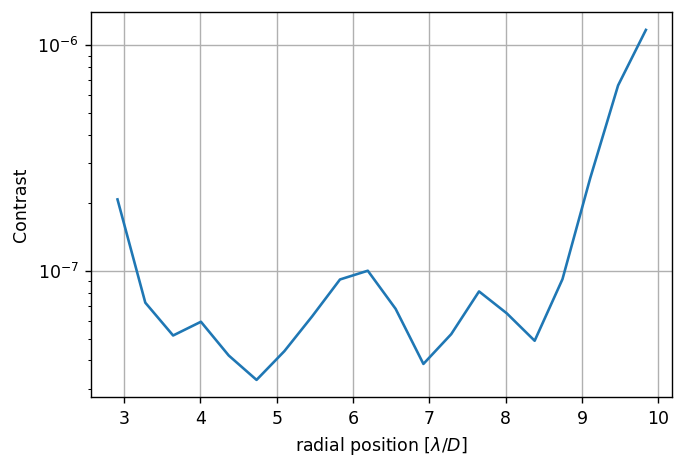

iEFC loop completed in 20.176s.


In [16]:
reload(lina.iefc)
reload(lina.utils)
model.reset_dm()

control_matrix = lina.utils.WeightedLeastSquares(response_matrix, weight_map, nprobes=2, rcond=1e-3)
    
images, dm_commands = lina.iefc.run(model, 
                              control_matrix,
                              probe_modes, 
                              probe_amp, 
                              calib_modes,
                              control_mask, 
                              num_iterations=5, 
                              loop_gain=0.5, 
                              leakage=0.0,
                              plot_all=True,
                             )

(5712, 5712) (5712, 228)
Running iEFC...
	Closed-loop iteration 1 / 5
(5712,)
(228, 5712)
	Mean NI of this iteration: 1.497e-07


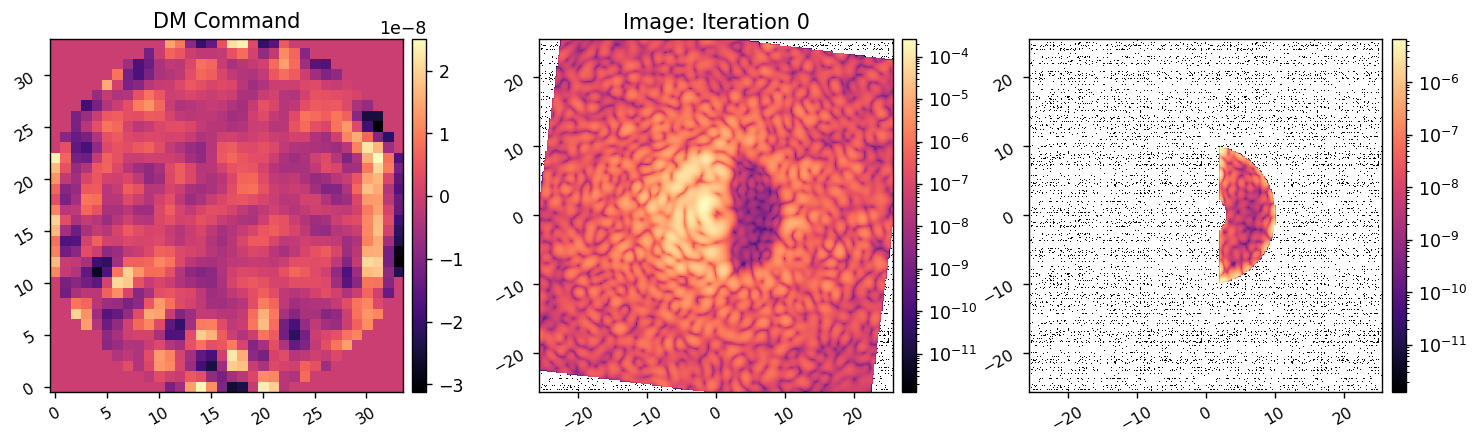

/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


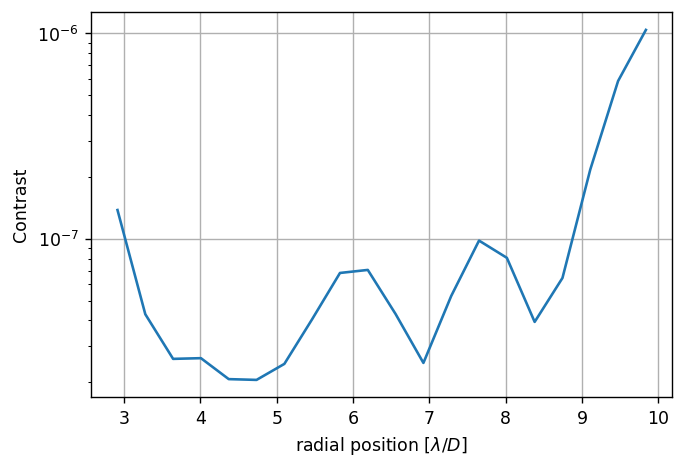

	Closed-loop iteration 2 / 5
(5712,)
(228, 5712)
	Mean NI of this iteration: 1.497e-07


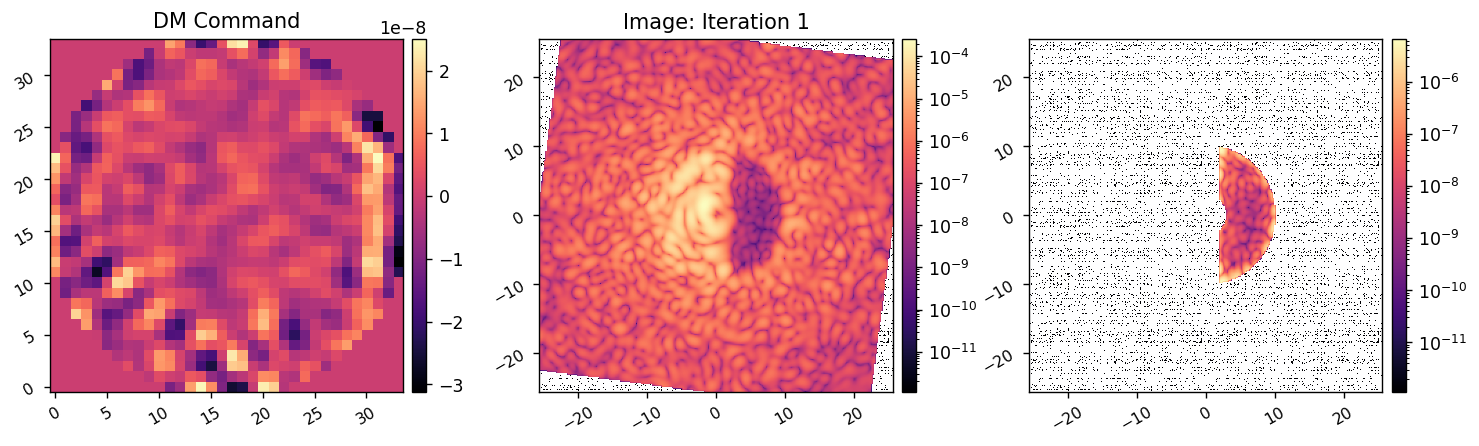

/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


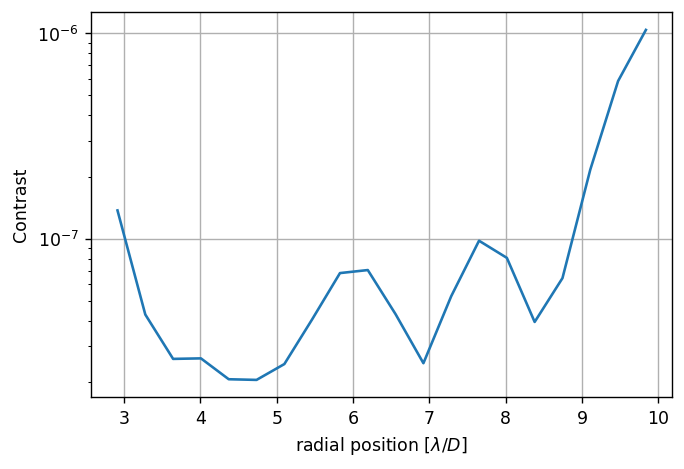

	Closed-loop iteration 3 / 5
(5712,)
(228, 5712)
	Mean NI of this iteration: 1.497e-07


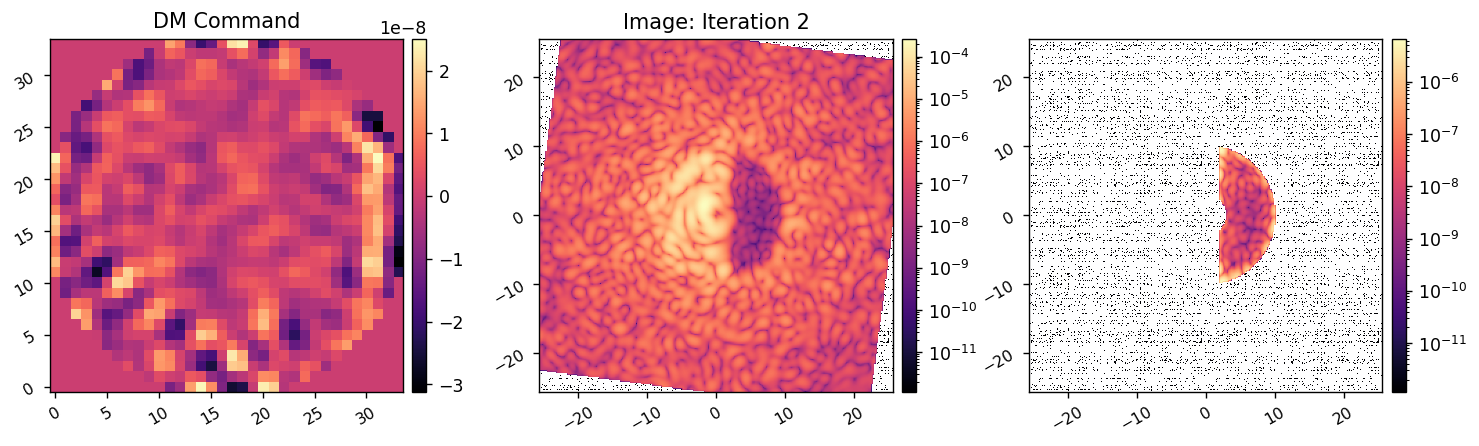

/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


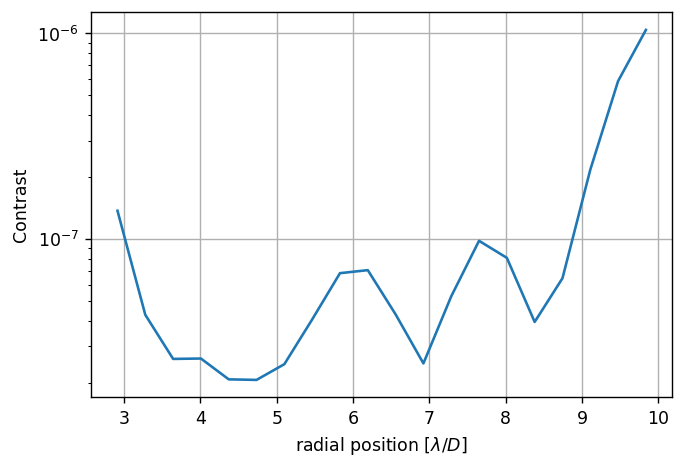

	Closed-loop iteration 4 / 5
(5712,)
(228, 5712)
	Mean NI of this iteration: 1.496e-07


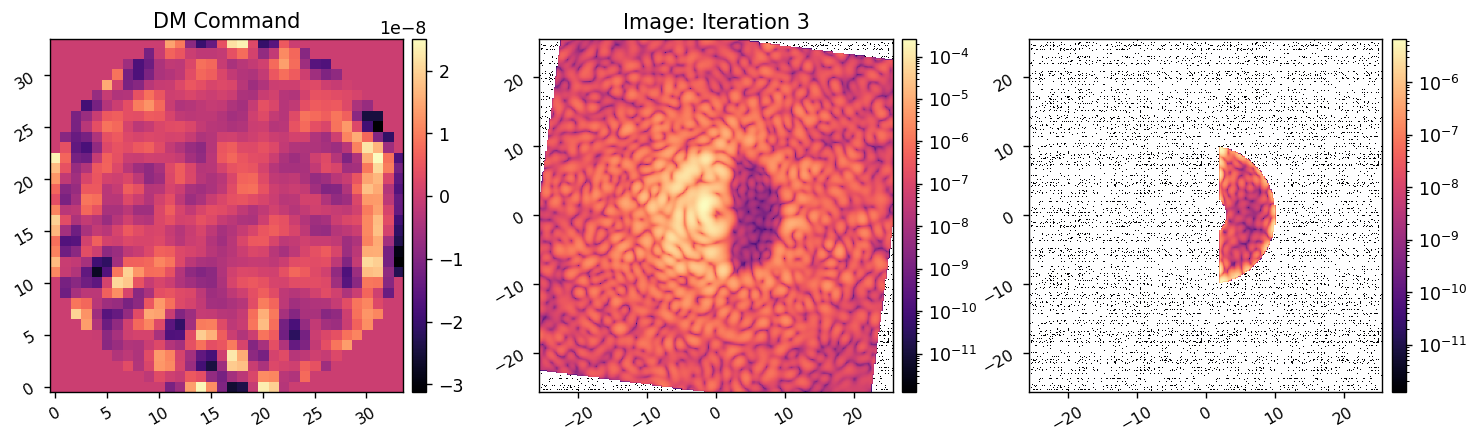

/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


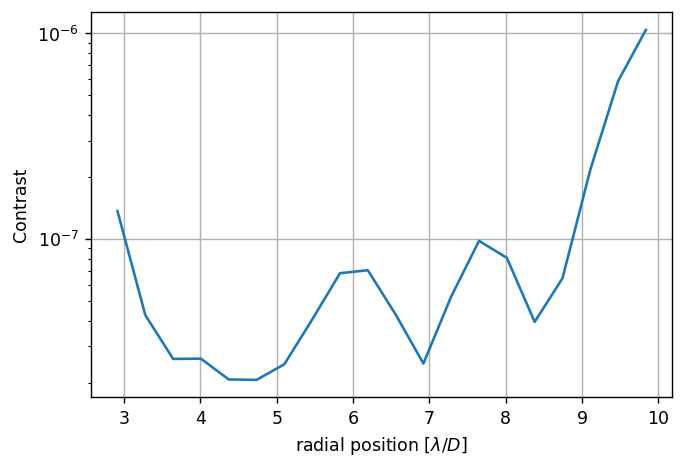

	Closed-loop iteration 5 / 5
(5712,)
(228, 5712)
	Mean NI of this iteration: 1.496e-07


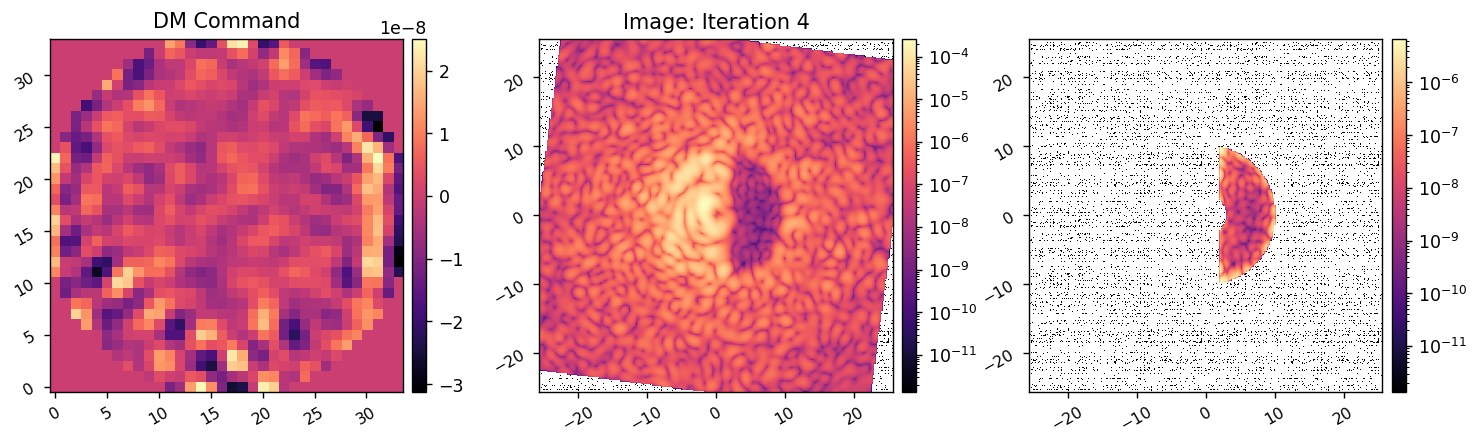

/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


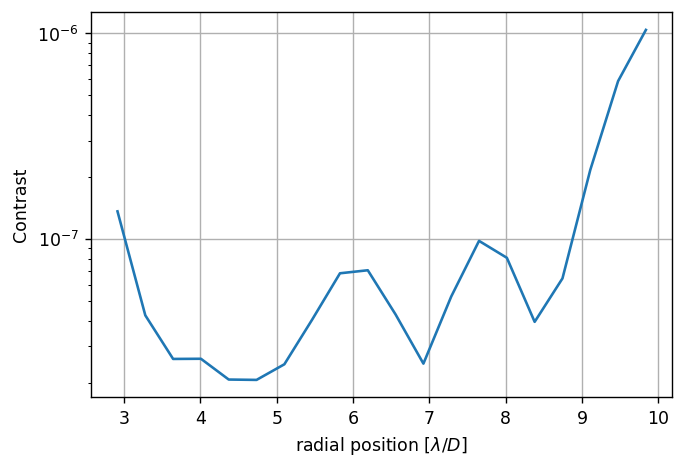

iEFC loop completed in 20.304s.


In [19]:
reload(lina.iefc)
reload(lina.utils)

control_matrix = lina.utils.WeightedLeastSquares(response_matrix, weight_map, nprobes=2, rcond=1e-1)
    
images, dm_commands = lina.iefc.run(model, 
                              control_matrix,
                              probe_modes, 
                              probe_amp, 
                              calib_modes,
                              control_mask, 
                              num_iterations=5, 
                              loop_gain=0.5, 
                              leakage=0.0,
                              plot_all=True,
                                    old_images=images,
                                    old_dm_commands=xp.array(dm_commands),
                             )

In [20]:
len(images)

10

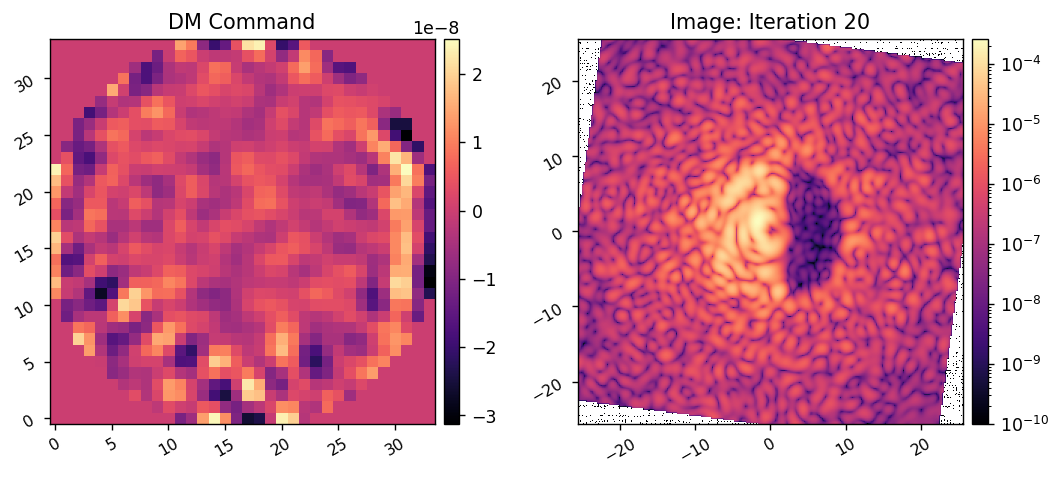

In [22]:
imshow2(dm_commands[-1], images[-1], 'DM Command', f'Image: Iteration {20}',
        lognorm2=True, 
       pxscl2=model.psf_pixelscale_lamD, vmin2=1e-10)